In [1]:
import networkx as nx
import math
import random
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt

In [2]:
def euclidean_distance(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)

In [3]:
def read_graph(file_path):
    with open(file_path) as f:
        g = nx.Graph()
        for line in f:
            if not line[0].isdigit():
                continue
            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)
            g.add_node(node, x=x, y=y)
        
        for u in g.nodes:
            for v in range(u + 1, len(g.nodes)):
                g.add_edge(u, v,
                           distance=euclidean_distance(g.nodes[u]['x'],
                                                        g.nodes[u]['y'],
                                                        g.nodes[v]['x'],
                                                        g.nodes[v]['y']))
        
        return g

In [4]:
graph = read_graph("dj38.tsp")

In [5]:
graph[0][1]["distance"]

290.99301545433866

In [6]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37))

In [7]:
def foo(path, g):
    length = 0
    for node in range(len(path) - 1):
        length += g[node][node + 1]["distance"]
        print(node, node + 1, g[node][node+1]["distance"])
    length += g[path[len(path)-1]][path[0]]["distance"]
    return length

In [8]:
foo([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], graph)

0 1 290.99301545433866
1 2 512.5409796925513
2 3 174.78753642319424
3 4 222.53897723520097
4 5 139.40600915631273
5 6 77.17623802732474
6 7 119.25859124784168
7 8 18.419453115936257
8 9 943.1662130201299
9 10 1195.7725623479646
10 11 69.96477879341072
11 12 332.40537704940243
12 13 748.9352631784059
13 14 735.6352723796917
14 15 298.4814404450145
15 16 19.2530109878937
16 17 11.827619382191655
17 18 5.36476386805619
18 19 472.0996331075131
19 20 850.9311316485309
20 21 978.969135908649
21 22 163.62644159453566
22 23 232.983368505136
23 24 214.14231340136712
24 25 27.46762887127465
25 26 640.610498482065
26 27 264.63350804508644
27 28 834.9219871925422


11655.132026750336

In [9]:
# kodiranje
# fitness
# ukrstanje
# selekcija
# mutacija

In [10]:
class Individual:
    def __init__(self, g):
        num_cities = len(g.nodes)
        self.code = np.random.permutation(num_cities).tolist()
        self.fitness = self.calc_fitness(g)
        
        
    def calc_fitness(self,g):
        length = 0
        n = len(self.code)
        for i in range(n-1):
            length += g[self.code[i]][self.code[i+1]]["distance"]
        length += g[self.code[-1]][self.code[0]]["distance"]
        return length
    
    def __lt__(self, other):
        return self.fitness < other.fitness

In [11]:
i = Individual(graph)

In [12]:
i.fitness

28588.990189964316

In [13]:
graph[27][28]["distance"]

834.9219871925422

In [14]:
len(i.code)

38

In [15]:
#for now, tournament selection
def selection(population, tournament_size,forbidden=None):
    allowed = list(set(range(len(population))).difference({forbidden}))
    chosen_indices = random.sample(allowed, tournament_size)
    best_fitness = float('inf')
    winner = None
    winner_idx = None
    for index in chosen_indices:
        if best_fitness > population[index].fitness:
            winner = population[index]
            winner_idx = index
            best_fitness = winner.fitness
    return winner,winner_idx

In [16]:
def crossover(parent1, parent2):
    
    n = len(parent1.code)
    child1 = []
    child2 = []
    
    breakpoint = random.randrange(n)
    
    child1.extend(parent1.code[:breakpoint])
    child2.extend(parent2.code[:breakpoint])
    
    for city in parent2.code:
        if city not in child1:
            child1.append(city)
    for city in parent1.code:
        if city not in child2:
            child2.append(city)
            
    return child1, child2

In [17]:
def mutation(child, mutation_prob):
    
    p = random.random()

    if p <= mutation_prob:
        n = len(child.code)
        random_index1 = random.randrange(n)
        allowed = list(set(range(n)).difference({random_index1}))
        random_index2 = random.choice(allowed)
        child.code[random_index1], child.code[random_index2] = child.code[random_index2], child.code[random_index1]
    

In [18]:
def local_search(graph,solution_after_shaking):
    n = len(solution_after_shaking.code)
    swaps=[]
    for i in range(n-1):
        for j in range(i+1,n):
            swaps.append((i,j))
    new_solution = Individual(graph)
    for i,j in swaps:
        new_solution.code[i], new_solution.code[j] = new_solution.code[j], new_solution.code[i]
        new_solution.fitness = new_solution.calc_fitness(graph)
        if new_solution.fitness < solution_after_shaking.fitness:
            solution_after_shaking.code[:] = new_solution.code[:]
            solution_after_shaking.fitness = new_solution.fitness
        

In [19]:
def shaking(solution, k):
    n = len(solution.code)
    new_solution = deepcopy(solution)
    for _ in range(k):
        i, j = random.sample(range(n), 2)
        new_solution.code[i], new_solution.code[j] = new_solution.code[j], new_solution.code[i]
    
    return new_solution
        

In [20]:
def vns(graph,individual, max_k, max_iter, move_prob):
    
    solution = deepcopy(individual)
    value = individual.fitness
    
    for i in range(max_iter):
        for k in range(max_k):
            new_solution = shaking(solution, k)
            local_search(graph,new_solution)
            
            new_solution.fitness = new_solution.calc_fitness(graph)
            new_value = new_solution.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution = deepcopy(new_solution)
        
    individual.code[:] = solution.code[:]
    individual.fitness = value

In [21]:
def vns_benchmark_version(graph,individual, max_k, max_iter, move_prob):
    
    solution = deepcopy(individual)
    value = individual.fitness
    tmp = []
    
    for i in range(max_iter):
        tmp.append(solution.fitness)
        for k in range(max_k):
            new_solution = shaking(solution, k)
            local_search(graph,new_solution)
            
            new_solution.fitness = new_solution.calc_fitness(graph)
            new_value = new_solution.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution = deepcopy(new_solution)
    
    plt.plot(range(max_iter), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    
    individual.code[:] = solution.code[:]
    individual.fitness = value

In [22]:
def rvns(graph,individual, max_k, max_iter, move_prob):
    
    solution = deepcopy(individual)
    value = individual.fitness
    
    for i in range(max_iter):
        for k in range(max_k):
            new_solution = shaking(solution, k)
            
            new_solution.fitness = new_solution.calc_fitness(graph)
            new_value = new_solution.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution = deepcopy(new_solution)
        
    individual.code[:] = solution.code[:]
    individual.fitness = value

## Pretraga uz pomoc VNS-a:

[17, 19, 16, 28, 23, 9, 0, 34, 3, 1, 37, 36, 26, 32, 8, 15, 7, 21, 18, 24, 31, 33, 25, 29, 27, 35, 2, 4, 22, 12, 5, 13, 14, 11, 6, 20, 30, 10]
24714.00119591673

[33, 26, 11, 6, 14, 19, 24, 25, 21, 22, 31, 13, 29, 23, 27, 17, 10, 16, 15, 2, 8, 7, 4, 5, 18, 28, 34, 32, 36, 1, 3, 12, 0, 20, 9, 30, 35, 37]
16482.75021078178


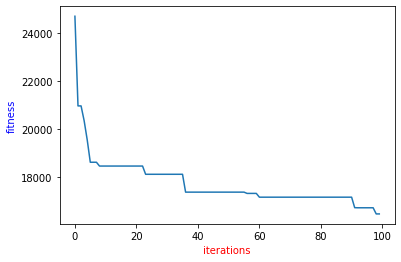

In [23]:
i1 = Individual(graph)
# i1.code = [8, 6, 3, 4, 0, 1, 5, 7, 12, 14, 17, 20, 25, 15, 13, 10, 9, 11, 18, 21, 22, 28, 19, 23, 26, 24, 27, 16, 2]
# i1.fitness = i1.calc_fitness(graph)
print(i1.code)
print(i1.fitness)
print()
vns_benchmark_version(graph,i1, 10, 100, 0.5)
print(i1.code)
print(i1.fitness)


## Genetski algoritam osnovna verzija:

In [24]:
def ga(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            
        #replace_population
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")
    
    #graph
    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    plt.show()
    

code: [30, 32, 33, 35, 37, 36, 34, 31, 25, 24, 22, 14, 12, 6, 4, 2, 3, 5, 7, 8, 11, 10, 16, 15, 23, 21, 19, 1, 0, 9, 13, 20, 28, 29, 27, 17, 18, 26]
fitness: 8753.260556485928


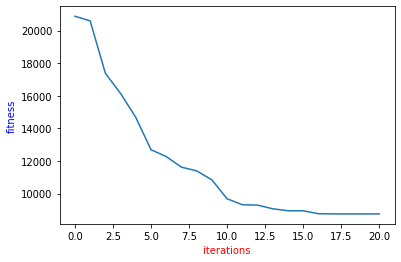

In [25]:
ga( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

## Hibrid genetski algoritam i redukovani vns:

In [26]:
def ga_rvns(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        rvns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    

code: [36, 34, 31, 29, 28, 25, 24, 22, 19, 21, 23, 14, 12, 8, 7, 6, 5, 4, 2, 3, 1, 0, 9, 20, 13, 11, 10, 15, 16, 17, 18, 27, 26, 30, 35, 33, 32, 37]
fitness: 7845.235407530119


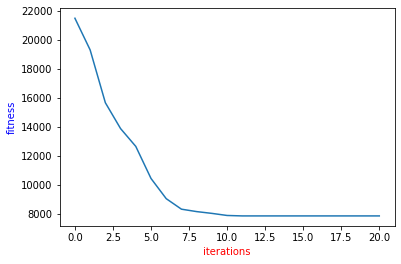

In [27]:
ga_rvns( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

## Hibrid genetski algoritam i VNS koji se primenjuje samo na najbolju jedinku u generaciji:

In [28]:
def ga_vns_best_only(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
                        
        #replace_population
        vns(graph,population[0], 7, 30, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    

code: [14, 12, 2, 4, 6, 8, 11, 10, 16, 17, 7, 5, 3, 1, 0, 9, 13, 20, 28, 31, 37, 36, 34, 29, 25, 24, 22, 27, 32, 33, 35, 30, 26, 18, 15, 23, 21, 19]
fitness: 8589.001681548223


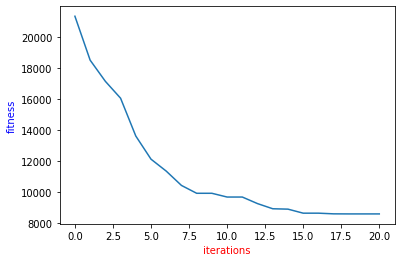

In [29]:
ga_vns_best_only( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

## Hibrid genetski algoritam i VNS koji se primenjuje na najbolju jedniku nakon kraja genetskog:

In [30]:
def ga_vns_piped(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    print(f'best indivudual fitness before another vns: {best_individual.fitness}')
    vns(graph, best_individual, 10, 100, 0.5)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)

best indivudual fitness before another vns: 8613.13713663331
code: [28, 36, 37, 32, 33, 35, 30, 26, 27, 23, 21, 24, 22, 19, 14, 15, 17, 16, 11, 10, 18, 34, 31, 29, 25, 12, 8, 7, 6, 5, 4, 2, 3, 1, 0, 9, 13, 20]
fitness: 8613.13713663331


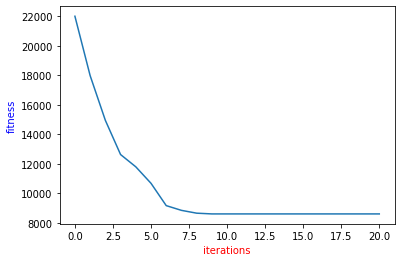

In [31]:
ga_vns_piped( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

## Hibrid genetski algoritam i VNS sa dinamicki promenljivom verovatnocom mutacije (povezana sa fitnesom jedinke):

In [32]:
def ga_rvns_dynamic_mutation_adjustment(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size, coef):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0

    for j in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(deepcopy(population[0]))
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best = min(population)
            tmp.append(deepcopy(current_best))
                        
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #mutation
            mutation(new_population[i],   mutation_prob - coef/new_population[i].fitness)
            mutation(new_population[i+1], mutation_prob - coef/new_population[i+1].fitness)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        vns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual)
    fitnesses = list(map(lambda x: x.fitness, tmp))
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), fitnesses)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    plt.show()
    
    

code: [1, 3, 2, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 23, 21, 19, 22, 24, 25, 28, 29, 31, 34, 36, 37, 32, 33, 35, 30, 26, 27, 12, 14, 13, 20, 9, 0]
fitness: 7693.227091626727


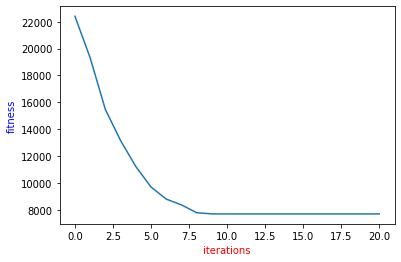

In [33]:
ga_rvns_dynamic_mutation_adjustment( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 30,
    mutation_prob = 0.2,
    tournament_size = 10,
    coef = 4000
    )

In [34]:
0.20 - 4*1000/40265

0.10065813982366821

## Hibrid genetksi algoritam i VNS (manja populacija i broj iteracija zbog velike slozenosti):

In [35]:
def ga_vns(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population)
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            vns(graph,new_population[i], 2, 5, 0.5)
            vns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        vns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    print(tmp)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    

[22703.84613467607, 19722.543154683775, 15387.613838381427, 11738.438022559863, 11513.125164400755, 11138.40491990613, 10946.243005881493, 10764.351422378659, 10759.080134848666, 10710.343853234259]
code: [10, 11, 8, 12, 14, 21, 19, 3, 1, 0, 29, 33, 35, 32, 34, 31, 28, 20, 9, 13, 22, 24, 25, 23, 27, 36, 37, 30, 26, 5, 2, 4, 6, 7, 15, 17, 18, 16]
fitness: 10702.25081585025


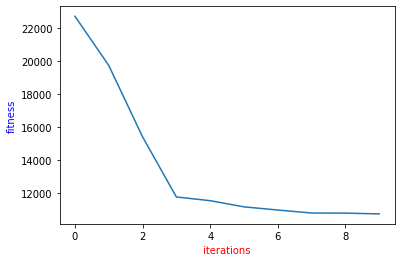

In [36]:
ga_vns( graph,
    num_iters = 10,
    use_elitism = True,
    population_size = 150,
    elitism_size = 16,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

# Hibrid ga + vns + dinamicka mutacija (povezana sa brojem iteracije)

In [37]:
def ga_rvns_dynamic_iteration_depandent_mutation(g,num_iters, use_elitism, elitism_size, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0

    for j in range(1,num_iters+1):
        if use_elitism:
            population.sort()
            tmp.append(deepcopy(population[0]))
            new_population[:elitism_size] = population[:elitism_size]
            
        else:
            current_best = min(population)
            tmp.append(deepcopy(current_best))
                        
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
                        
            #mutation
            mutation(new_population[i],  1/(2*j))
            mutation(new_population[i+1],1/(2*j))
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        vns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual)
    fitnesses = list(map(lambda x: x.fitness, tmp))
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(1,num_iters+2), fitnesses, marker = "x")
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    plt.show()

code: [14, 12, 2, 4, 6, 8, 7, 5, 3, 1, 0, 9, 13, 20, 28, 36, 37, 32, 33, 35, 30, 26, 27, 23, 34, 31, 29, 25, 24, 22, 19, 21, 11, 10, 18, 17, 16, 15]
fitness: 8350.978581327878


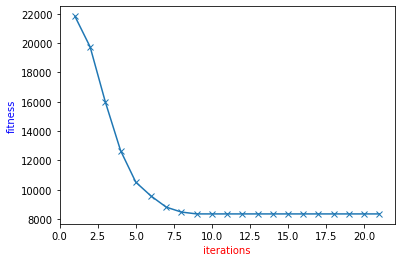

In [38]:
ga_rvns_dynamic_iteration_depandent_mutation( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    tournament_size = 10,
    )